In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt

In [2]:
startdate = "2022-11-30"
enddate = "2023-06-20"

In [3]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'

In [4]:
sos_fn = '../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet'
sos_df = pd.read_parquet(sos_fn)

# Examine synoptic winds, with doppler lidar (PPI/VAD)

### Open files

In [5]:
SAIL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DATA_STREAM_FILEEXT = '.nc'
output_dir = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SAIL_DATA_STREAM)

In [6]:
# act.discovery.download_arm_data(username, token, SAIL_DATA_STREAM, startdate, enddate, output=output_dir)

In [7]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")

In [8]:
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files[0:1000])
prof_ds.time.min(), prof_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-30T00:00:39.646250000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-06-15T23:59:20.789108000', dtype='datetime64[ns]'))

In [9]:
prof_df = prof_ds.to_dataframe()
prof_df = utils.modify_df_timezone(prof_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')

In [10]:
synoptic_winds_30min = prof_df.query("height > 900").query("height < 2000")[['wind_speed', 'wind_direction']].reset_index().set_index('time').groupby(pd.Grouper(freq='30min')).mean().ffill()

# Plot wind rose with wind-direction categories

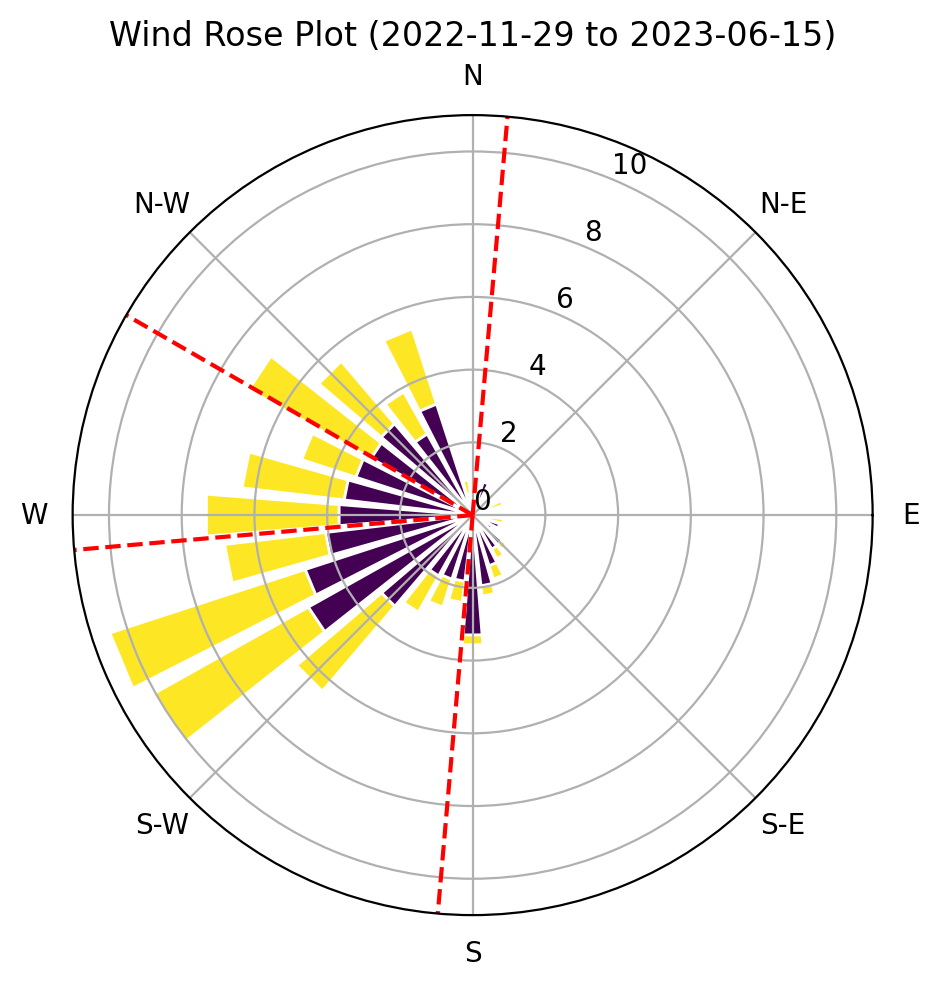

In [11]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np
# Create a wind rose plot
fig = plt.figure(figsize=(5,5), dpi=200) 
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(
    synoptic_winds_30min['wind_direction'], synoptic_winds_30min['wind_speed'], 
    edgecolor='white', opening=0.8, 
    normed=True,
    nsector=32,
    # bins = np.arange(0, 31, 6)
    bins = np.arange(0, 20, 10)
)

# Add a line at theta = 299 degrees
# theta = np.deg2rad(-299 + 90)  # Convert degrees to radians
# ax.plot([np.deg2rad(-202 + 90), np.deg2rad(-202 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-248 + 90), np.deg2rad(-248 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-299 + 90), np.deg2rad(-299 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-345 + 90), np.deg2rad(-345 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-185 + 90), np.deg2rad(-185 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-265 + 90), np.deg2rad(-265 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-300 + 90), np.deg2rad(-300 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-5 + 90), np.deg2rad(-5 + 90)], [0, 19], color='red', linestyle='--')

# Customize the plot
ax.set_title(f"Wind Rose Plot ({synoptic_winds_30min.index.min().date()} to {synoptic_winds_30min.index.max().date()})")
# ax.set_legend(title="Frequency (%)", loc='lower right')
ax.set_ylim(0,11)
ax.set_yticks(np.arange(0, 12, step=2))
ax.set_yticklabels(np.arange(0, 12, step=2))
# ax.set_xlim(0.5*np.pi,1.5*np.pi)
plt.show()

# Create synoptic wind speed/direction categories and save to files 

Speed categories

In [12]:
winds_ge10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed > 10 ] 
winds_le10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed <= 10 ] 

Direction categories

In [13]:
# along_valley_wind_times = synoptic_winds_30min[
#     (synoptic_winds_30min.wind_direction > 299)
#     & (synoptic_winds_30min.wind_direction < 345 )
# ].index.values
# cross_valley_wind_times = synoptic_winds_30min[
#     (synoptic_winds_30min.wind_direction > 202)
#     & (synoptic_winds_30min.wind_direction < 270 )
# ].index.values
# len(cross_valley_wind_times), len(along_valley_wind_times)


# Better option??
# 185-265, 
# 300 - 5

along_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 300)
    | (synoptic_winds_30min.wind_direction < 5 )
].index.values
cross_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 185)
    & (synoptic_winds_30min.wind_direction < 265 )
].index.values
len(cross_valley_wind_times), len(along_valley_wind_times)



(4037, 2089)

In [14]:
cross_valley_wind_times = pd.Series(cross_valley_wind_times)
along_valley_wind_times = pd.Series(along_valley_wind_times)

In [15]:
cross_valley_wind_times.to_csv('cross_valley_wind_times.csv')
along_valley_wind_times.to_csv('along_valley_wind_times.csv')
pd.Series(winds_ge10_times.index).to_csv('winds_ge10_times.csv')
pd.Series(winds_le10_times.index).to_csv('winds_le10_times.csv')

In [ ]:
cross_valley_wind_times.to_csv('cross_valley_wind_times.csv')
along_valley_wind_times.to_csv('along_valley_wind_times.csv')
pd.Series(winds_ge10_times.index).to_csv('winds_ge10_times.csv')
pd.Series(winds_le10_times.index).to_csv('winds_le10_times.csv')

# Examine synoptic wind statistics

In [16]:
synoptic_winds_pdf_data = pd.concat([
        synoptic_winds_30min[synoptic_winds_30min.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        synoptic_winds_30min[synoptic_winds_30min.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])

<Axes: ylabel='Frequency'>

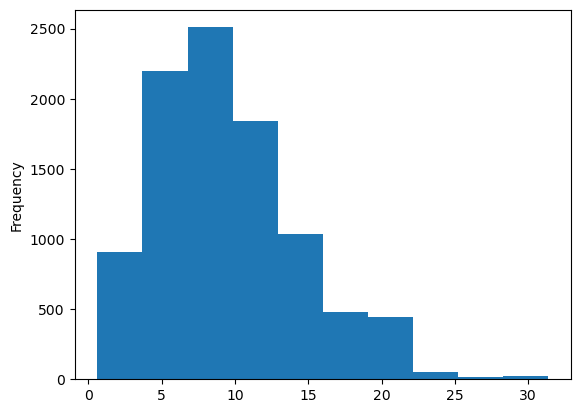

In [17]:
synoptic_winds_30min.wind_speed.plot.hist()

In [18]:
top_20_max_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d'))[['wind_speed']].max().sort_values('wind_speed', ascending=False).head(20).index
top_20_avg_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d'))[['wind_speed']].mean().sort_values('wind_speed', ascending=False).head(20).index

In [19]:
for datetime in top_20_max_windspeed_days:
    cross_cnt = len(cross_valley_wind_times[cross_valley_wind_times.dt.date == datetime.date()])
    along_cnt = len(along_valley_wind_times[along_valley_wind_times.dt.date == datetime.date()])
    if cross_cnt > along_cnt:
        print(datetime.date())
        print('cross', cross_cnt)
        print('along', along_cnt)
        print()

2023-03-04
cross 46
along 0

2023-04-19
cross 35
along 1

2023-02-19
cross 20
along 2

2023-04-03
cross 47
along 0

2023-02-24
cross 46
along 0

2023-03-08
cross 46
along 0

2023-02-18
cross 43
along 0

2023-02-22
cross 31
along 0

2023-03-10
cross 45
along 0

2023-04-04
cross 27
along 6

2023-03-22
cross 45
along 0

2022-12-01
cross 48
along 0

2023-02-20
cross 15
along 3

2023-02-23
cross 47
along 0

2022-12-03
cross 42
along 0

2022-12-02
cross 39
along 0

2023-04-02
cross 16
along 0



In [20]:
for datetime in top_20_avg_windspeed_days:
    cross_cnt = len(cross_valley_wind_times[cross_valley_wind_times.dt.date == datetime.date()])
    along_cnt = len(along_valley_wind_times[along_valley_wind_times.dt.date == datetime.date()])
    if cross_cnt > along_cnt:
        print(datetime.date())
        print('cross', cross_cnt)
        print('along', along_cnt)
        print()

2023-03-29
cross 44
along 0

2023-04-03
cross 47
along 0

2023-02-22
cross 31
along 0

2023-02-24
cross 46
along 0

2023-03-08
cross 46
along 0

2023-04-02
cross 16
along 0

2022-12-11
cross 48
along 0

2023-02-05
cross 11
along 0

2023-03-04
cross 46
along 0

2023-03-22
cross 45
along 0

2022-12-12
cross 12
along 2

2023-02-25
cross 48
along 0

2023-03-07
cross 48
along 0

2023-02-28
cross 37
along 1

2023-01-29
cross 35
along 0



In [21]:
top_12_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d')).max().sort_values('wind_speed', ascending=False).head(12).index
top_12_windspeed_days[0]
for dt in top_12_windspeed_days:
    print(len(cross_valley_wind_times[cross_valley_wind_times.dt.date == dt.date]))
    print(len(along_valley_wind_times[along_valley_wind_times.dt.date == dt.date]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [22]:
synoptic_winds_pdf_data.index.min(), synoptic_winds_pdf_data.index.max()

(Timestamp('2022-11-29 18:30:00'), Timestamp('2023-06-15 17:30:00'))

In [23]:
synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d')).max().wind_speed.quantile(0.90)

22.332079

In [35]:
synoptic_winds_pdf_data.synoptic_wind.value_counts()

synoptic_wind
cross valley    4037
along valley    2089
Name: count, dtype: int64

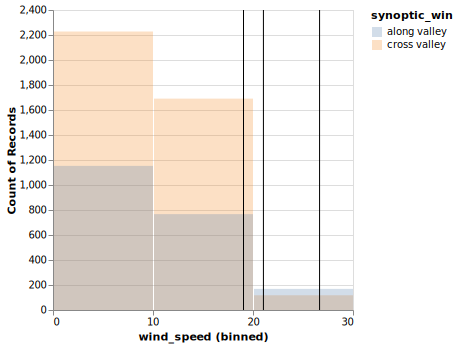

In [31]:
alt.Chart(synoptic_winds_pdf_data).mark_bar(opacity=0.25).encode(
    alt.X('wind_speed:Q').bin(step=10),
    alt.Y('count():Q', stack=False),
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

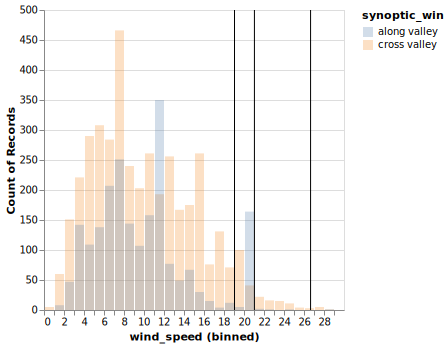

In [24]:
alt.Chart(synoptic_winds_pdf_data).mark_bar(opacity=0.25).encode(
    alt.X('wind_speed:Q').bin(step=1),
    alt.Y('count():Q', stack=False),
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

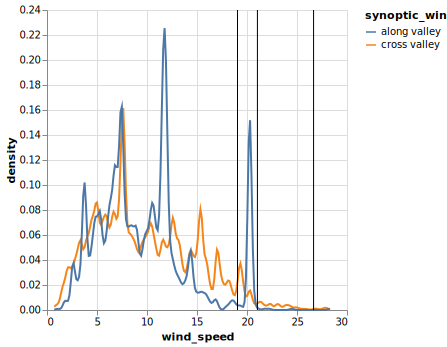

In [70]:
alt.Chart(synoptic_winds_pdf_data).transform_density(
    'wind_speed',
    as_=['wind_speed', 'density'],
    groupby = ['synoptic_wind'],
    bandwidth=0.2,
).mark_line().encode(
    x='wind_speed:Q',
    y='density:Q',
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

# Examine vertical profiles of vertical velocity statistics, with doppler lidar (vertical staring)

In [67]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)

Download between start and end date

In [68]:
file_list = act.discovery.download_arm_data(
    username, token, DLW_DATA_STREAM, '20230409', '20230409', output = DLW_OUTPUT_DIR
)

[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230409.000000.nc

If you use these data to prepare a publication, please cite:

Shippert, T., Newsom, R., Riihimaki, L., & Zhang, D. Doppler Lidar Vertical
Velocity Statistics (DLPROFWSTATS4NEWS), 2023-04-09 to 2023-04-09, ARM Mobile
Facility (GUC), Gunnison, CO; AMF2 (main site for SAIL) (M1). Atmospheric
Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1178583



Or just open existing files between start and end date

In [69]:
files = glob.glob(os.path.join(DLW_OUTPUT_DIR, "*.nc"))
# Function to extract date from filename (adjust regex or slicing as needed)
def extract_date(filename):
    # Assuming filenames have a format like "data_YYYYMMDD.nc"
    basename = os.path.basename(filename)
    date_str = basename.split('gucdlprofwstats4newsM1.c1.')[1].split('.000000')[0]  # Adjust based on your filename format
    return date_str

# Filter files based on date range
file_list = [
    file for file in files
    if startdate.replace('-','') <= extract_date(file) <= enddate.replace('-','')
]

In [ ]:
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

In [ ]:
dl_wstats.time.min(), dl_wstats.time.max()

In [ ]:
df_wstats = dl_wstats[['w_variance', 'w_skewness', 'snr']].to_dataframe()
df_wstats = df_wstats[df_wstats.snr > 0.008]

In [ ]:
df_wstats_30min = df_wstats.reset_index().set_index('time').groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index()
df_wstats_30min


## Variance

In [ ]:
df_wstats_along_valley = df_wstats_30min[df_wstats_30min.time.isin(along_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'along-valley')
df_wstats_cross_valley = df_wstats_30min[df_wstats_30min.time.isin(cross_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'cross-valley')

df_wstats_with_synoptic_conditions = pd.concat([
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10')
])

#### Median plot for April 18

In [ ]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_variance_profile_smooth = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_variance)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'"),
    alt.Y('height:Q').axis(None),
    order='height:Q'
)
apr18_2000_2100_median_variance_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black', strokeDash=[2,2]).transform_window(
    rolling_avg = 'mean(w_variance)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_variance):Q").title("w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)

In [ ]:
df_wvariance_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].median().rename('w_variance_median'),
], axis=1).reset_index()

plot_wvariance_iqr_slowwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_slowwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_iqr_fastwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_fastwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

(
    (apr18_2000_2100_median_variance_profile_smooth + apr18_2000_2100_median_variance_profile)
    | 
    (
        (plot_wvariance_iqr_slowwinds + plot_wvariance_median_slowwinds) 
        | 
        (plot_wvariance_iqr_fastwinds + plot_wvariance_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='independent')

## Skewness

#### Median plot for April 18

In [ ]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
src = src[src.snr > 0.008]

In [ ]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_skewness_profile_smooth = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'").scale(domain=[-1, 2], clamp=True),
    alt.Y('height:Q').axis(None),
    order='height:Q'
)
apr18_2000_2100_median_skewness_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black', strokeDash=[2,2]).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_skewness):Q").title("w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)
apr18_2000_2100_median_skewness_profile_smooth + apr18_2000_2100_median_skewness_profile

In [ ]:
df_wskewness_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].median().rename('w_skewness_median'),
], axis=1).reset_index()

plot_wskewness_iqr_slowwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1, 2], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_median_slowwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_iqr_fastwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1, 2], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_median_fastwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

(
    (apr18_2000_2100_median_skewness_profile_smooth + apr18_2000_2100_median_skewness_profile)
    | 
    (
        (plot_wskewness_iqr_slowwinds + plot_wskewness_median_slowwinds) 
        | 
        (plot_wskewness_iqr_fastwinds + plot_wskewness_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='independent')

In [ ]:
df_wskewness_stats = pd.concat([
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_with_synoptic_conditions.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].median().rename('w_skewness_median'),
], axis=1).reset_index()

(alt.Chart(df_wskewness_stats).mark_rule().encode(
    alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.X2('w_skewness_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wskewness_stats).mark_circle(size=20).encode(
    alt.X('w_skewness_median:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]).title("w'w'w' median and IQR"),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'synoptic_wind_speed'
)
# apr18_2000_2100_median_skewness_profile_smooth
# apr18_2000_2100_median_skewness_profile

In [ ]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
alt.Chart(
    src[src.snr > 0.008].loc['20230418 1800': '20230418 2359'].reset_index()
).mark_line(strokeWidth=5).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'w'"),
    alt.Y('height:Q'),
    alt.Color('hours(time):O').scale(scheme='accent'),
    order='height:Q'
).configure_legend(
    titleFontSize=12,  # Adjust title font size
    labelFontSize=12,  # Adjust label font size
    symbolSize=300,
    symbolStrokeWidth=7   # Adjust symbol size
).properties(width=200, height=200).display(renderer='svg')

In [ ]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_skewness_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)
apr18_2000_2100_median_skewness_profile

Median plots with April 18 profiles

In [ ]:
slow_wind_speed_median_variance_chart = (
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)

fast_wind_speed_median_variance_chart = (
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)
(
    slow_wind_speed_median_variance_chart 
    | (
        fast_wind_speed_median_variance_chart + apr18_2000_2100_median_variance_profile
    ).resolve_scale(x='independent')
).resolve_scale(x='shared', y='shared', color='shared')

In [ ]:
slow_wind_speed_median_skewness_chart = (
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1.5, 1.5], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)

fast_wind_speed_median_skewness_chart = (
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1.5, 1.5], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300) + 
    alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
)
(
    slow_wind_speed_median_skewness_chart 
    | fast_wind_speed_median_skewness_chart + apr18_2000_2100_median_skewness_profile
).resolve_scale(x='shared', y='shared', color='shared')

In [ ]:
(alt.Chart(
    df_wstats_cross_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_skewness)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150) & alt.Chart(
    df_wstats_along_valley.set_index('time').join(synoptic_winds_30min)
).mark_line().encode(
    alt.X('mean(w_skewness)'),
    alt.Y('height:Q'),
    alt.Facet('wind_speed').bin(),
    order='height'
).properties(width=150)).resolve_scale(y='shared', x='shared')

In [ ]:
df_wskewness_stats = pd.concat([
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_cross_valley_with_synoptic_wind_bins.groupby(['height', 'synoptic_wind_direction', 'wind_speed_bin'])['w_skewness'].mean().rename('w_skewness_mean'),
], axis=1).reset_index()

In [ ]:
(alt.Chart(df_wskewness_stats).mark_rule().encode(
    alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.X2('w_skewness_uqr:Q'),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300) + alt.Chart(df_wskewness_stats).mark_circle(size=20).encode(
    alt.X('w_skewness_mean:Q').scale(domain=[-1, 1], clamp=True).axis(values=[-1,0,1]),
    alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
    alt.YOffset('synoptic_wind_direction:N'),
    alt.Color('synoptic_wind_direction'),
).properties(height=300)).facet(
    column = 'wind_speed_bin'
)

# Compare wind direction shear and mixing intensity

In [ ]:
wprof_resampled_ds = prof_df.groupby([pd.Grouper(freq='30min'), 'height'])[['wind_speed', 'wind_direction']].mean().to_xarray()
wprof_resampled_df = wprof_resampled_ds.to_dataframe()
wprof_resampled_df_smooth = pd.DataFrame(
    wprof_resampled_df.groupby(level=0).wind_direction.apply(lambda x: x.rolling(window=3, min_periods=1).mean())
).droplevel(0).query("height < 2000")

In [ ]:
alt.Chart(wprof_resampled_df_smooth.loc['20230418 1500':'20230418 1800'].reset_index()).mark_line().encode(
    alt.X('wind_direction:Q'),
    alt.Y('height:Q'),
    alt.Facet('hoursminutes(time):O'),
    order='height'
).properties(width=100, height=200)